# Capstone Analytic Report - Kristofer Schobert

## An Exploration of Data on Olympic Athletes

The data we will be investigating contains information on the Olympic athletes from the Athens games in 1896 to the Rio games in 2016. It is a large data set (5 MB) and contains 271116 rows and 15 columns of information. Some columns of interest are: the athletes' name, sex, height, event, and year they participated. 

This data was gathered by a group of dedicated Olympic history enthusiasts who shared their findings at www.sports-reference.com. The Kaggle user, Randi H Griffin, then consolidated their data into one dataset and posted it on Kaggle: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home. For more information on this group of Olympic enthusiasts, check out their blog: http://olympstats.com/.

Let's begin our exploration of this data by viewing the first few rows.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
%matplotlib inline

dataframe = pd.read_csv('athlete_events.csv')
df = pd.DataFrame(dataframe)
df.head(7)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN


As we can see, some individuals appear in multiple rows. Each row contains data on one competator of a particular event. Thus, if one athlete competed in N number of Olympic events during their life, they will be the subject of N rows. Also, we will have several 'NaN' values in the Medal column because many athletes did not win a medal. There are also many missing height and weight values. 

NOTE: The unit of height is centimeters and the unit of weight is kilograms. 


# The Inclusion of Women

There are many interesting questions one may ask about this data. The first we will dive into is the inclusion of women in the Olympics throughout the years. 

Let's create a plot showing the percentage of female athletes for each year of the Olympic Games.

In [4]:
#Lets make two lists of data to count the number of male athletes and female athletes per year. 
#We will call one male and the other female. These lists will be lists containing years. Each year will represent
#an athlete whom competed that year.
#NOTE: If an athlete competed in multiple events in a given year, he/she will be only counted once for that year.

current_name = None
current_year = None
female = []
male = []
for i in range(0,len(df['Name'])):
    if (df['Name'][i], df['Year'][i]) != (current_name, current_year) and df['Sex'][i] == 'F':
        female.append(df['Year'][i])
        current_name = df['Name'][i]
        current_year = df['Year'][i]
    elif  (df['Name'][i], df['Year'][i]) != (current_name, current_year) and df['Sex'][i] == 'M':
        male.append(df['Year'][i])
        current_name = df['Name'][i]
        current_year = df['Year'][i]
    

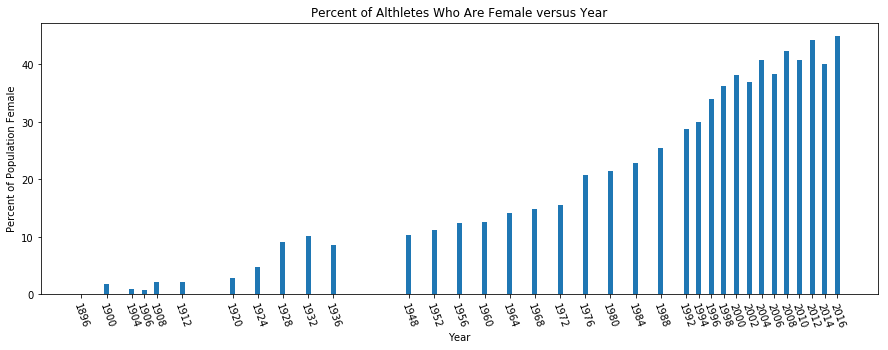

In [30]:
#creating a plot of the percent of women vs year. We start by creating a dictionary with the keys being the years 
#and the values being a list with the number of men as the zeroth element and the number of women being the next element. 

#first let's create a sorted list containing every year of the Olympic Games
year_list = sorted(list(set(male)))
#print(year_list)

year_sex_count = []

for i in range(0,len(year_list)):
    year_sex_count.append([year_list[i], male.count(year_list[i]), female.count(year_list[i])])

year_sex_count_array = np.array(year_sex_count) 
#print(year_sex_count_array)
fem_percent = year_sex_count_array[:,2]*100/(year_sex_count_array[:,1]+year_sex_count_array[:,2])

plt.figure(figsize=(15, 5))
plt.bar(year_list,fem_percent)
plt.title('Percent of Althletes Who Are Female versus Year')
plt.xlabel('Year')
plt.xticks(year_sex_count_array[:,0], rotation=290)
plt.ylabel('Percent of Population Female')
plt.show()

There are many interesting features of this plot. In general, the percentage of female athletes has increased overtime. There were no women competing in Athens in 1896, but nearly half of the athletes were women in the 2016 Rio Games. The percentage of women seems to be approaching fifty percent.  

Some interesting facts about the Olympics are reflected in this data. Due to World War I, there were no games held in 1918, and due to World War II, there were no 1940 or 1944 games. Also, the Summer and Winter Olympic Games were held during the same year through 1992. The International Olympic Committee chose to stagger the games every two years beginning with the Winter Games of 1994. This is clearly shown in our data. Lastly, the 1906 Olympic Games, held in Athens, were at the time considered to be official, but have since decreased in legitimacy. The metals awarded at these games are not recognized by the International Olympic Committee. Our data does include these games, and we will continue to include them in our exploration. 

citing sources:
https://en.wikipedia.org/wiki/Olympic_Games
https://en.wikipedia.org/wiki/1906_Intercalated_Games


# Discrepancies in Athlete Height by Event


While the inclusion of women in the Olympic Games is of great importance and interest, let's turn our attention to some of the physical data we have on our athletes -  their height. 

With the data we have, we can ask questions about the heights of certain athletes. Let's compare the heights of male marathon runners, male 400 meter sprinters, and male 100 meter sprinters. We will be sure to include each athlete only once. 

NOTE: We will be taking the athlete's height during his first year of competition if he competed multiple years. There may be some athletes who competed in two or more different events (e.g. 100 meters and 400 meters). They will be included once per event. 

In [10]:
current_name_mar = None
current_name_100 = None
current_name_400 = None
marathon_height = []
hundred_meters_height = []
four_hundred_meters_height = []
for i in range(0,len(df['Name'])):
    if df['Name'][i] != current_name_mar and df['Event'][i] == "Athletics Men's Marathon":
        marathon_height.append(df['Height'][i])
        current_name_mar = df['Name'][i]
    elif  df['Name'][i] != current_name_100 and df['Event'][i] == "Athletics Men's 100 metres":
        hundred_meters_height.append(df['Height'][i])
        current_name_100 = df['Name'][i]
    elif  df['Name'][i] != current_name_400 and df['Event'][i] == "Athletics Men's 400 metres":
        four_hundred_meters_height.append(df['Height'][i])
        current_name_400 = df['Name'][i]
        
cleaned_marathon_height = [x for x in marathon_height if str(x) != 'nan']
cleaned_hundred_meters_height = [x for x in hundred_meters_height if str(x) != 'nan']
cleaned_four_hundred_meters_height = [x for x in four_hundred_meters_height if str(x) != 'nan']

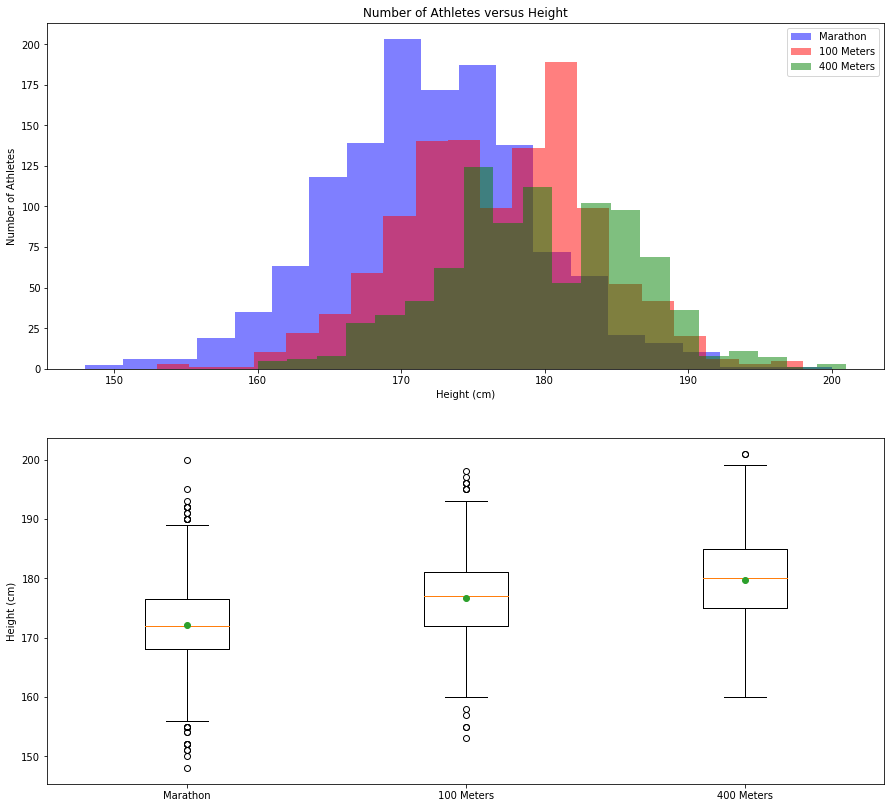

Marathon mean = 172.04 cm = 5 feet 7.73 inches
    100m mean = 176.62 cm = 5 feet 9.54 inches
    400m mean = 179.65 cm = 5 feet 10.73 inches


In [102]:
plt.figure(figsize=(15, 14))

plt.subplot(2,1,1)
hist_marathon = plt.hist(cleaned_marathon_height, bins=20, color='blue', alpha=.5, label='Marathon') 
hist_100 = plt.hist(cleaned_hundred_meters_height, bins=20, color='red', alpha=.5, label='100 Meters')
hist_400 = plt.hist(cleaned_four_hundred_meters_height, bins=20, color='green', alpha=.5, label='400 Meters')
plt.title('Number of Athletes versus Height')
plt.xlabel('Height (cm)')
plt.ylabel('Number of Athletes')
plt.legend()

plt.subplot(2,1,2)

plt.boxplot([cleaned_marathon_height, cleaned_hundred_meters_height, cleaned_four_hundred_meters_height], showmeans=True, meanprops=dict(marker='o'))
plt.xticks([1,2,3],['Marathon', '100 Meters', '400 Meters'])
plt.ylabel('Height (cm)')

plt.show()

print("Marathon mean = " + str(round(np.mean(cleaned_marathon_height), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_marathon_height) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_marathon_height) * 0.0328084  % 1) * 12, 2)) + ' inches')
print("    100m mean = " + str(round(np.mean(cleaned_hundred_meters_height), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_hundred_meters_height) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_hundred_meters_height) * 0.0328084  % 1) * 12, 2)) + ' inches')
print("    400m mean = " + str(round(np.mean(cleaned_four_hundred_meters_height), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_four_hundred_meters_height) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_four_hundred_meters_height) * 0.0328084  % 1) * 12, 2)) + ' inches')   

As we can see from these figures, the male athletes who competed in these events are noticeably different in height. The histograms and boxplots show strikingly different distributions for each of the events. All three distributions look to be normal as we would expect. The marathon runners are the shortest in height, the 400 meter runners are tallest, and 100 meter runners are in between. The mean of each distribution is shown in the boxplots with a green circle. The IQRs of these three distributions are roughly the same and so are their whisker lengths. Marathon runners have the greatest number of extreme values and also the largest range in height. 

Let's investigate the p-values to see if the discrepancy in means of their heights is statistically significant. Perhaps the variance in the three samples is large enough to keep us from claiming that the means of our samples are significantly different from eachother. 

In [44]:
print(ttest_ind(cleaned_hundred_meters_height, cleaned_marathon_height, equal_var=False))
print(ttest_ind(cleaned_four_hundred_meters_height, cleaned_hundred_meters_height, equal_var=False))
print(ttest_ind(cleaned_four_hundred_meters_height, cleaned_marathon_height, equal_var=False))

print(mannwhitneyu(cleaned_hundred_meters_height, cleaned_marathon_height, 
                   use_continuity=True, alternative='two-sided'))
print(mannwhitneyu(cleaned_four_hundred_meters_height, cleaned_hundred_meters_height, 
                   use_continuity=True, alternative='two-sided'))
print(mannwhitneyu(cleaned_four_hundred_meters_height, cleaned_marathon_height, 
                   use_continuity=True, alternative='two-sided'))

Ttest_indResult(statistic=16.547512419972243, pvalue=2.398330698328637e-58)
Ttest_indResult(statistic=10.264428550398149, pvalue=4.182368261529645e-24)
Ttest_indResult(statistic=25.77811637958881, pvalue=1.0772738552129853e-126)
MannwhitneyuResult(statistic=1007614.0, pvalue=8.519842405310362e-58)
MannwhitneyuResult(statistic=649774.0, pvalue=9.070281082570416e-23)
MannwhitneyuResult(statistic=896298.0, pvalue=8.642366797318679e-116)


We have used both a t-test and a Mann Whitney U test to see if our distributions are indeed different. We see that the p-values of all three comparisons between all three means in both tests are vanishingly small. The likelihood that any two of these samples were drawn from the same original population is essentially zero. We can claim with absurdly high confidence that these means are truly different. These althetes come from different populations in terms of their height.  

# The Change in Height of High Jump Olympians Over Time

It is certainly interesting to find that the average height of a male Olympic runner can vary by event. Maybe the average height of athletes in one event has changed significantly over time. Let's take the high jump as our event. First, we would like a plot of the mean height of male and female high jumpers versus time. 

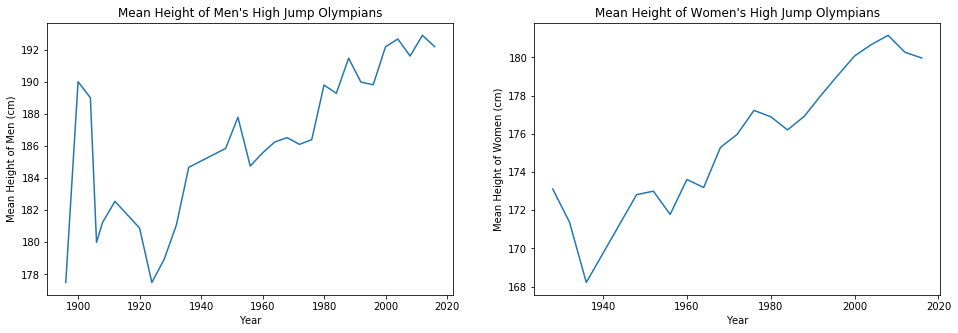

In [47]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(df[df['Event'] == 'Athletics Men\'s High Jump'
           ].groupby('Year')['Height'].describe()['mean'])
plt.ylabel('Mean Height of Men (cm)')
plt.xlabel('Year')
plt.title('Mean Height of Men\'s High Jump Olympians')

plt.subplot(1,2,2)
plt.plot(df[df['Event'] == 'Athletics Women\'s High Jump'
           ].groupby('Year')['Height'].describe()['mean'])
plt.ylabel('Mean Height of Women (cm)')
plt.xlabel('Year')
plt.title('Mean Height of Women\'s High Jump Olympians')
plt.show()

These plots seem to show a general trend of increasing height, but without knowledge of the standard error of each of these means, we cannot conclude that the mean heights of high jumpers have gone up. To make our analysis simpler, let's split the high jumpers into two groups. One group contains the athletes who competed during the 1980 Moscow Games or before, and the other group will be those who competed after those 1980 games. We will count athletes who competed in the high jump competition during multiple years, once for each year he/she competed. We are interested in the mean height of a given year, thus it is appropriate to include the entire group of jumpers each year in this manner. 

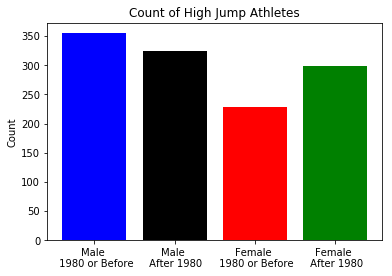

In [20]:
cut_year = 1980

male_pre1980 = list(df[df["Year"] <= cut_year][df[df["Year"] <= cut_year]['Event'] == 'Athletics Men\'s High Jump']['Height'])
male_post1980 = list(df[df["Year"] > cut_year][df[df["Year"] > cut_year]['Event'] == 'Athletics Men\'s High Jump']['Height'])

fem_pre1980 = list(df[df["Year"] <= cut_year][df[df["Year"] <= cut_year]['Event'] == 'Athletics Women\'s High Jump']['Height'])
fem_post1980 = list(df[df["Year"] > cut_year][df[df["Year"] > cut_year]['Event'] == 'Athletics Women\'s High Jump']['Height'])



cleaned_male_pre1980 = [x for x in male_pre1980 if str(x) != 'nan']
cleaned_male_post1980 = [x for x in male_post1980 if str(x) != 'nan']

cleaned_fem_pre1980 = [x for x in fem_pre1980 if str(x) != 'nan']
cleaned_fem_post1980 = [x for x in fem_post1980 if str(x) != 'nan']

plt.figure()


plt.bar([1,2,3,4],[len(cleaned_male_pre1980), len(cleaned_male_post1980), len(cleaned_fem_pre1980), len(cleaned_fem_post1980)], 
        color=['b','black','red','green'])
plt.xticks([1,2,3,4],['Male \n 1980 or Before', 'Male \n After 1980', 'Female \n 1980 or Before', 'Female \n After 1980'], rotation = 0)
plt.ylabel('Count')
plt.title('Count of High Jump Athletes')
plt.show()


The figure above shows how many male and female high jump athletes we have height data on. (There are a large amount of 'NaN' values in the heights column of out dataset). The Moscow Games of 1980 are a reasonable year to use as our cutoff. Because females were underrepresented in earlier games, the number of female high jumpers before our cutoff is less than the number of females after. However, this cutoff yields more male high jumpers before rather than after. After trying a few different cutoff years, I feel 1980 is appropriate. 

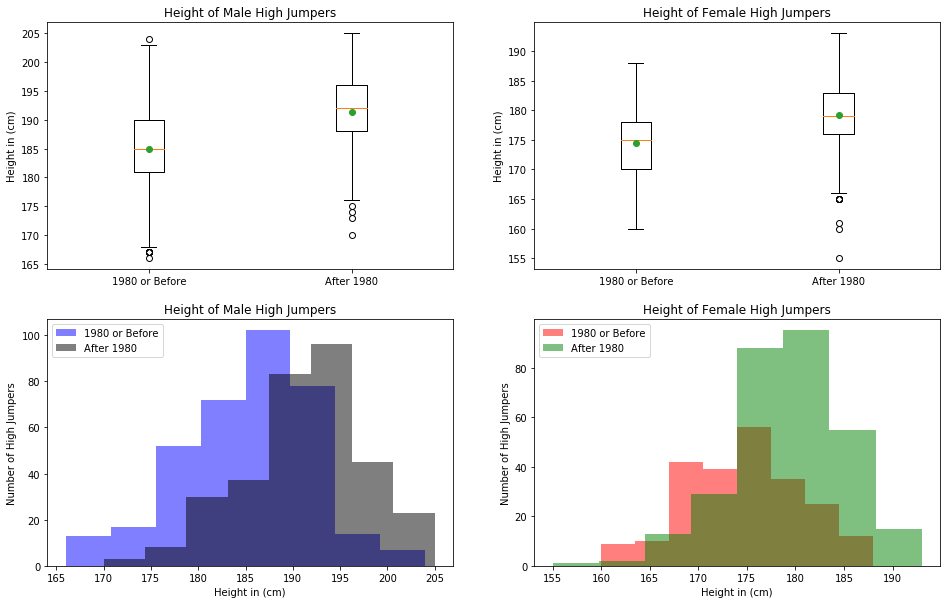

  Men 1980 or before mean = 184.95 cm = 6 feet 0.81 inches
      Men after 1980 mean = 191.37 cm = 6 feet 3.34 inches
Women 1980 or before mean = 174.5  cm = 5 feet 8.7 inches
    Women after 1980 mean = 179.25 cm = 5 feet 10.57 inches


In [111]:


plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.boxplot([cleaned_male_pre1980, cleaned_male_post1980], showmeans=True, meanprops=dict(marker='o'))
plt.title('Height of Male High Jumpers')
plt.ylabel('Height in (cm)')
plt.xticks([1,2],['1980 or Before', 'After 1980'])

plt.subplot(2,2,2)
plt.boxplot([cleaned_fem_pre1980, cleaned_fem_post1980], showmeans=True, meanprops=dict(marker='o'))
plt.title('Height of Female High Jumpers')
plt.ylabel('Height in (cm)')
plt.xticks([1,2],['1980 or Before', 'After 1980'])

plt.subplot(2,2,3)
plt.hist(cleaned_male_pre1980, color="b", bins=8, alpha=.5, label='1980 or Before')
plt.hist(cleaned_male_post1980, color="black", bins=8, alpha=.5, label='After 1980')
plt.title('Height of Male High Jumpers')
plt.xlabel('Height in (cm)')
plt.ylabel('Number of High Jumpers')
plt.legend()

plt.subplot(2,2,4)
plt.hist(cleaned_fem_pre1980, color="red", bins=8, alpha=.5, label='1980 or Before')
plt.hist(cleaned_fem_post1980, color="green", bins=8, alpha=.5, label='After 1980')
plt.title('Height of Female High Jumpers')
plt.xlabel('Height in (cm)')
plt.ylabel('Number of High Jumpers')
plt.legend()

plt.show()

print("  Men 1980 or before mean = " + str(round(np.mean(cleaned_male_pre1980), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_male_pre1980) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_male_pre1980) * 0.0328084  % 1) * 12, 2)) + ' inches')
print("      Men after 1980 mean = " + str(round(np.mean(cleaned_male_post1980), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_male_post1980) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_male_post1980) * 0.0328084  % 1) * 12, 2)) + ' inches')
print("Women 1980 or before mean = " + str(round(np.mean(cleaned_fem_pre1980), 2)) + '  cm = ' +
      str(int(np.mean(cleaned_fem_pre1980) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_fem_pre1980) * 0.0328084  % 1) * 12, 2)) + ' inches')
print("    Women after 1980 mean = " + str(round(np.mean(cleaned_fem_post1980), 2)) + ' cm = ' +
      str(int(np.mean(cleaned_fem_post1980) * 0.0328084  // 1)) + ' feet ' + 
      str(round((np.mean(cleaned_fem_post1980) * 0.0328084  % 1) * 12, 2)) + ' inches')


From these boxplots and histograms, we see that the distributions we are comparing look very different. It seems true that Olympic High Jump athletes after 1980 were on average taller than those during the 1980 Moscow Games and before. To test if this discrepancy in their means is truly significant we will take a t-test and a Mann Whitney U test.

In [46]:
print(ttest_ind(cleaned_male_pre1980, cleaned_male_post1980, equal_var=False))
print(ttest_ind(cleaned_fem_pre1980, cleaned_fem_post1980, equal_var=False))
print(mannwhitneyu(cleaned_male_pre1980, cleaned_male_post1980, 
                   use_continuity=True, alternative='two-sided'))
print(mannwhitneyu(cleaned_fem_pre1980, cleaned_fem_post1980, 
                   use_continuity=True, alternative='two-sided'))

Ttest_indResult(statistic=-12.767615987626167, pvalue=1.3249751941455864e-33)
Ttest_indResult(statistic=-8.964262480716165, pvalue=6.175075711545806e-18)
MannwhitneyuResult(statistic=27420.5, pvalue=2.2890565895165736e-32)
MannwhitneyuResult(statistic=19152.0, pvalue=8.583361190217795e-18)


We see that both p-values are extremely small in both test. The likelihood that high jump males from before and after our cutoff are drawn from the same population is negligibly small. The same goes for the female high jump athletes. We can claim with extremely high confidence that both male and female Olympic high jump athletes are taller on average after the 1980 games than they were during and before those games.


# Further Research Proposal Ideas

We have seen how the inclusion of women has changed over time and how the heights of high jumpers have changed. Developing a predictive model to predict the future of these statistics would be very exciting. One would train the model on the data we have and extrapolate to estimate the future of these variables. 

One would hope that the percentage of female athletes per Olympic games continues to approach 50%. Will the average height of an Olympic high jump athlete increase forever? Approach some asymptotic height? What about the future average heights of athletes in other events? Wouldn't it be nice to create a general algorithm that takes in the past height data from any given event and predict the future mean heights of those athletes? These are all intriguing questions which data science can investigate. We could refine our models after each Olympics to gain more accurate predictions and perhaps have some inkling to what the future holds for our Olympians.